# **Introducción a la IA** — Hoja de **Ejemplos** (Lecture 2)
## Filtros, Convoluciones y Transformaciones Básicas
**Fecha:** 2025-10-06

> **Uso:** pensado para **Google Colab** o local. Cambia **1–2 parámetros** en cada bloque **TRY IT** y vuelve a ejecutar.
> Cuaderno **auto-contenido**: genera imágenes sintéticas y no requiere internet.


---
## 🎯 Objetivos
- Entender la operación de **convolución** y su aplicación a imágenes.
- Probar **filtros**: media, gaussiano, Sobel (bordes), realce y emboss.
- Practicar **transformaciones**: traslación, escalado, rotación (NN).
- Explorar **modos de padding** y **umbralización** de bordes.


In [ ]:

# === Preparación del entorno ===
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120

def show(img, title=None):
    plt.figure(figsize=(5,3))
    if img.ndim == 2:
        plt.imshow(img, cmap='gray', vmin=float(img.min()), vmax=float(img.max()))
    else:
        plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off'); plt.show()

def to_gray(img):
    if img.ndim == 2:
        g = img.astype(np.float32)
    else:
        g = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.float32)
    return g

def pad2d(im, pad, mode='reflect'):
    H, W = im.shape
    if mode == 'zero':
        out = np.zeros((H+2*pad, W+2*pad), dtype=im.dtype)
        out[pad:pad+H, pad:pad+W] = im
        return out
    elif mode in ('edge', 'reflect'):
        return np.pad(im, pad_width=pad, mode=mode).astype(im.dtype)
    else:
        raise ValueError("mode debe ser 'zero', 'edge' o 'reflect'")

def conv2d_gray(im, K, mode='reflect'):
    im = im.astype(np.float32)
    kH, kW = K.shape
    assert kH % 2 == 1 and kW % 2 == 1, "K debe tener tamaño impar"
    p = max(kH//2, kW//2)
    pim = pad2d(im, p, mode=mode)
    H, W = im.shape
    out = np.zeros((H, W), dtype=np.float32)
    for i in range(H):
        for j in range(W):
            patch = pim[i:i+kH, j:j+kW]
            out[i,j] = np.sum(patch * K)
    return out

def normalize01(im):
    im = im.astype(np.float32)
    mn, mx = float(im.min()), float(im.max())
    if mx - mn < 1e-8:
        return np.zeros_like(im)
    return (im - mn) / (mx - mn)

def gaussian_kernel(size=3, sigma=1.0):
    assert size % 2 == 1, "size debe ser impar"
    r = size//2
    ax = np.arange(-r, r+1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    K = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
    K /= K.sum()
    return K.astype(np.float32)

def translate_nn(img, tx=0, ty=0, fill=0):
    # tx: +derecha, ty: +abajo
    H, W = img.shape[:2]
    out = np.zeros_like(img)
    out.fill(fill)
    x0 = max(0, tx); x1 = min(W, W+tx)
    y0 = max(0, ty); y1 = min(H, H+ty)
    sx0 = max(0, -tx); sy0 = max(0, -ty)
    if img.ndim == 2:
        out[sy0:sy0+(y1-y0), sx0:sx0+(x1-x0)] = img[y0:y1, x0:x1]
    else:
        out[sy0:sy0+(y1-y0), sx0:sx0+(x1-x0), :] = img[y0:y1, x0:x1, :]
    return out

def scale_nn(img, sx=1.0, sy=1.0):
    H, W = img.shape[:2]
    H2, W2 = max(1, int(round(H*sy))), max(1, int(round(W*sx)))
    out = np.zeros((H2, W2, img.shape[2]) if img.ndim==3 else (H2, W2), dtype=img.dtype)
    for yy in range(H2):
        for xx in range(W2):
            ys = min(H-1, max(0, int(round(yy/sy)))) if sy!=0 else 0
            xs = min(W-1, max(0, int(round(xx/sx)))) if sx!=0 else 0
            out[yy, xx] = img[ys, xs]
    return out

def rotate_nn(img, angle_deg=0, fill=0):
    # Rotación alrededor del centro, inversa + NN
    H, W = img.shape[:2]
    angle = np.deg2rad(angle_deg)
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    cx, cy = (W-1)/2.0, (H-1)/2.0
    out = np.zeros_like(img); out.fill(fill)
    for y in range(H):
        for x in range(W):
            xo = (x - cx)*cos_a + (y - cy)*sin_a + cx
            yo = -(x - cx)*sin_a + (y - cy)*cos_a + cy
            xi, yi = int(round(xo)), int(round(yo))
            if 0 <= xi < W and 0 <= yi < H:
                out[y, x] = img[yi, xi]
    return out

print("Entorno listo ✔")


Entorno listo ✔


---
## 0) Imagen base (sintética)
**TRY IT:** ajusta tamaño, degradados y figuras para probar filtros.


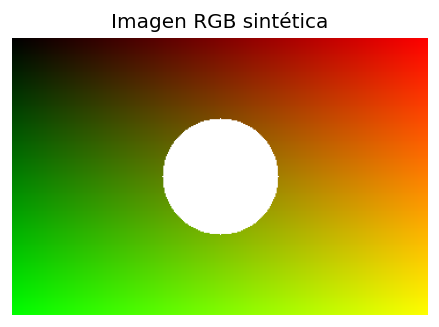

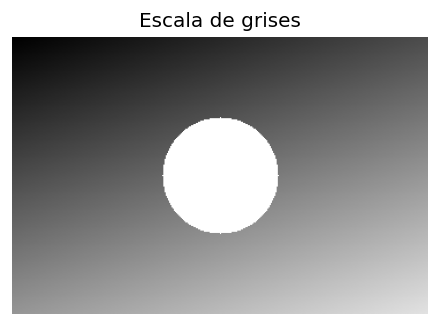

In [ ]:

# === PARÁMETROS (modifica) ===
H, W = 240, 360
add_circle = True; circle_radius = 50
add_square = False; sq = (40, 60, 120, 140)  # (y0,x0,y1,x1)
gradient_R = True; gradient_G = True; gradient_B = False
# === FIN ===

x = np.linspace(0, 1, W); y = np.linspace(0, 1, H)
X, Y = np.meshgrid(x, y)

R = (X*255).astype(np.uint8) if gradient_R else np.zeros((H,W), np.uint8)
G = (Y*255).astype(np.uint8) if gradient_G else np.zeros((H,W), np.uint8)
B = ((1-X)*255).astype(np.uint8) if gradient_B else np.zeros((H,W), np.uint8)

img = np.stack([R, G, B], axis=2)

if add_circle:
    YY, XX = np.ogrid[:H, :W]
    mask = (XX - W//2)**2 + (YY - H//2)**2 <= circle_radius**2
    img[mask] = 255
if add_square:
    y0, x0, y1, x1 = sq
    img[y0:y1, x0:x1] = 0

g = to_gray(img)
show(img, "Imagen RGB sintética")
show(g,  "Escala de grises")


Forma de la imagen (alto, ancho): (591, 396, 3)


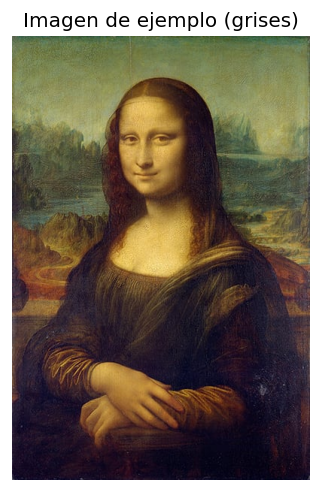

In [37]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('1_Mona_Lisa_300ppi.jpg')  # cambia la ruta si estás en Colab
arr = np.array(img) #Contiene la matriz imagen
print('Forma de la imagen (alto, ancho):', arr.shape)
plt.imshow(arr, cmap='gray')
plt.title('Imagen de ejemplo (grises)')
plt.axis('off')
plt.show()

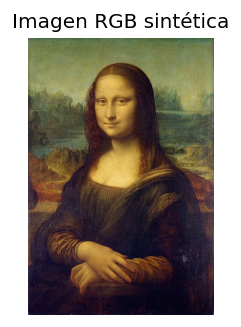

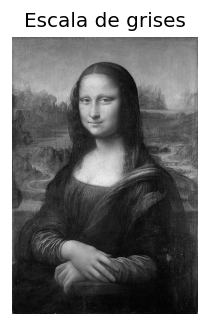

In [42]:
g = to_gray(arr)
show(arr, "Imagen RGB sintética")
show(g,  "Escala de grises")

---
## 1) Convolución genérica (kernel editable)
**TRY IT:** cambia `K` y `mode`. Ejemplos: media 3×3, realce, emboss, laplaciano.


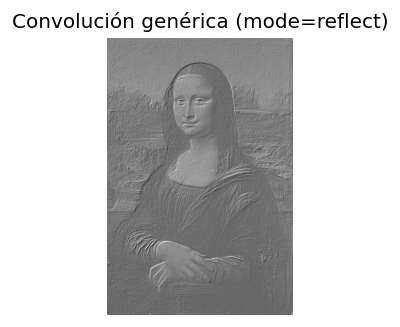

In [45]:

# === PARÁMETROS (modifica) ===
K = np.array([[-2, -1, 0],
              [-1,1, 1],
              [0, 1, 2]], dtype=np.float32)  # Laplaciano (resalta bordes)
mode = 'reflect'  # 'zero' | 'edge' | 'reflect'
# === FIN ===

out = conv2d_gray(g, K, mode=mode)
show(normalize01(out), f"Convolución genérica (mode={mode})")


---
## 2) Filtro de media k×k
**TRY IT:** ajusta `k` (impar) y observa el suavizado y la pérdida de detalle.


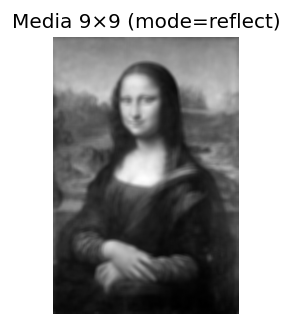

In [46]:

# === PARÁMETROS (modifica) ===
k = 9   # impar: 3,5,7...
mode = 'reflect'
# === FIN ===

assert k % 2 == 1, "k debe ser impar"
K = np.ones((k,k), dtype=np.float32) / (k*k)
smooth = conv2d_gray(g, K, mode=mode)
show(normalize01(smooth), f"Media {k}×{k} (mode={mode})")


---
## 3) Filtro Gaussiano
**TRY IT:** ajusta `size` y `sigma`. Más `sigma` → más desenfoque.


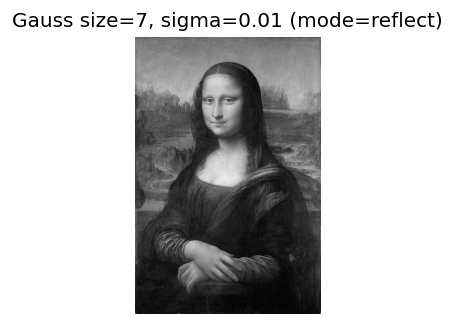

In [49]:

# === PARÁMETROS (modifica) ===
size = 7     # impar
sigma = 0.01
mode = 'reflect'
# === FIN ===

K = gaussian_kernel(size=size, sigma=sigma)
gauss = conv2d_gray(g, K, mode=mode)
show(normalize01(gauss), f"Gauss size={size}, sigma={sigma} (mode={mode})")


---
## 4) Realce (Unsharp Mask)
**TRY IT:** cambia `sigma` y `alpha`.


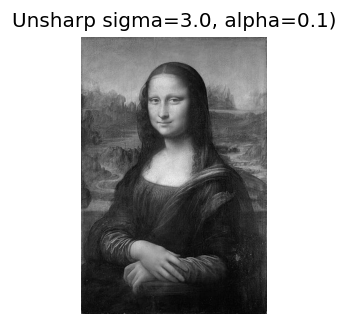

In [50]:

# === PARÁMETROS (modifica) ===
sigma = 3.0
alpha = 0.1  # peso de realce
# === FIN ===

blur = conv2d_gray(g, gaussian_kernel(5, sigma), mode='reflect')
detail = g - blur
sharp = np.clip(g + alpha*detail, 0, 255)
show(normalize01(sharp), f"Unsharp sigma={sigma}, alpha={alpha})")


---
## 5) Bordes con Sobel
**TRY IT:** visualiza `g_x`, `g_y` y la magnitud.


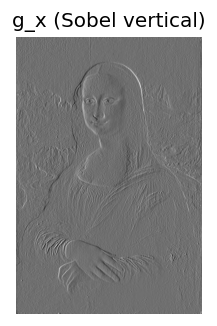

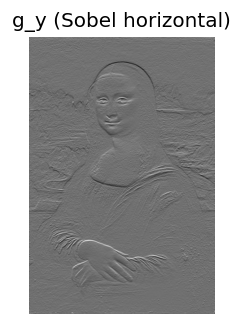

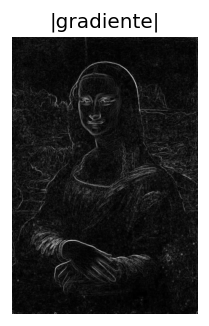

In [51]:

Gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
Gy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32)

gx = conv2d_gray(g, Gx, mode='reflect')
gy = conv2d_gray(g, Gy, mode='reflect')
mag = np.sqrt(gx**2 + gy**2)

show(normalize01(gx), "g_x (Sobel vertical)")
show(normalize01(gy), "g_y (Sobel horizontal)")
show(normalize01(mag), "|gradiente|")


---
## 6) Umbralización de bordes
**TRY IT:** ajusta `t` para binarizar la magnitud del gradiente.


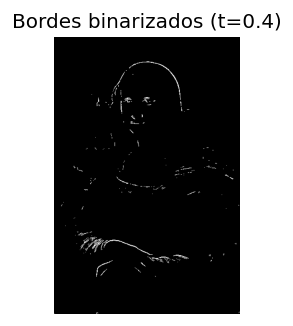

In [56]:

# === PARÁMETROS (modifica) ===
t = 0.4  # umbral en [0,1]
# === FIN ===

# Recalcular 'mag' para independencia de orden de ejecución
Gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
Gy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32)
gx = conv2d_gray(g, Gx, mode='reflect')
gy = conv2d_gray(g, Gy, mode='reflect')
M = normalize01(np.sqrt(gx**2 + gy**2))
edges = (M >= t).astype(np.float32)
show(edges, f"Bordes binarizados (t={t})")


---
## 7) Emboss (relieve)
**TRY IT:** cambia el kernel para variar la dirección del relieve.


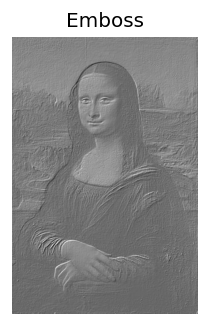

In [57]:

# === PARÁMETROS (modifica) ===
K = np.array([[-2,-1,0],
              [-1, 1,1],
              [ 0, 1,2]], dtype=np.float32)
mode = 'reflect'
# === FIN ===

emb = conv2d_gray(g, K, mode=mode)
show(normalize01(emb), "Emboss")


---
## 8) Transformaciones geométricas (NN)
**TRY IT:** mueve (`tx,ty`), escala (`sx,sy`) y rota (`angle_deg`).


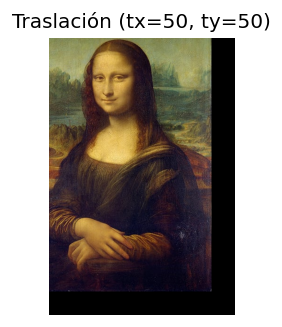

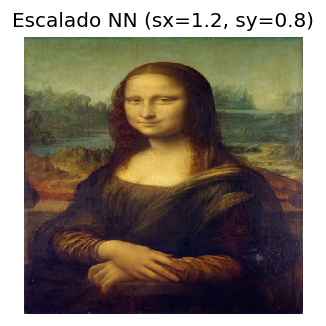

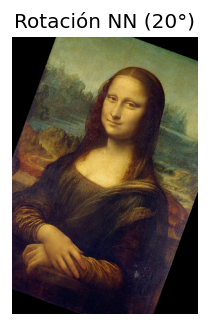

In [61]:
# === PARÁMETROS (modifica) ===
tx, ty = 50, 50
sx, sy = 1.2, 0.8
angle_deg = 20
# === FIN ===

# Convert PIL Image to NumPy array if it's not already
# The variable containing the NumPy array is 'arr' as clarified by the user.
img_array = arr


img_t = translate_nn(img_array, tx=tx, ty=ty, fill=0)
img_s = scale_nn(img_array, sx=sx, sy=sy)
img_r = rotate_nn(img_array, angle_deg=angle_deg, fill=0)

show(img_t, f"Traslación (tx={tx}, ty={ty})")
show(img_s, f"Escalado NN (sx={sx}, sy={sy})")
show(img_r, f"Rotación NN ({angle_deg}°)")

---
## 9) Comparativa de padding
**TRY IT:** observa el efecto del padding con un filtro de realce.


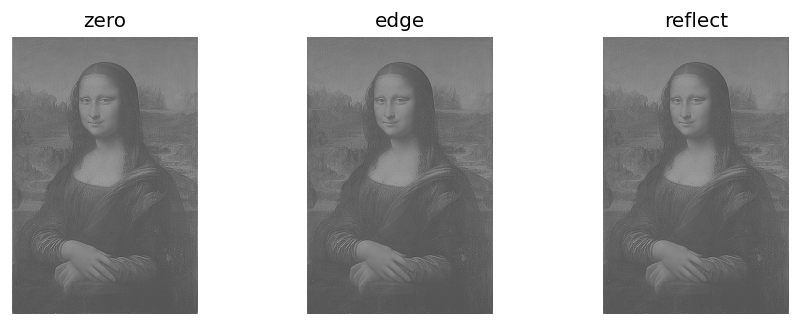

In [62]:

K = np.array([[0,-1,0],
              [-1,5,-1],
              [0,-1,0]], dtype=np.float32)  # realce simple

out_zero = conv2d_gray(g, K, mode='zero')
out_edge = conv2d_gray(g, K, mode='edge')
out_refl = conv2d_gray(g, K, mode='reflect')

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(normalize01(out_zero), cmap='gray'); plt.title('zero'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(normalize01(out_edge), cmap='gray'); plt.title('edge'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(normalize01(out_refl), cmap='gray'); plt.title('reflect'); plt.axis('off')
plt.show()


---
## 10) Guardar imagen
**TRY IT:** elige qué variable guardar como PNG.


In [63]:

# === PARÁMETROS (modifica) ===
filename = "lecture2_result.png"
image_to_save = normalize01(mag) if 'mag' in globals() else g
# === FIN ===

plt.imsave(filename, image_to_save, cmap='gray' if image_to_save.ndim==2 else None)
print("Guardado:", filename)


Guardado: lecture2_result.png


---
# ✅ Mini‑cuestionario (auto‑corregible) — Lecture 2

Cambia **solo lo necesario** en cada bloque *TRY IT* y ejecuta para ver si pasa las comprobaciones.


### 1) Filtro de **media 3×3**
**TRY IT:** completa la función `mean3x3(im, mode)` usando convolución con `K = ones(3,3)/9`.
Al ejecutar, verás si **pasa** la verificación.


In [ ]:

import numpy as np

# === TODO: completa esta función ===
def mean3x3(im, mode='reflect'):
    K = np.ones((3,3), dtype=np.float32) / 9.0
    return conv2d_gray(im, K, mode=mode)

# --- Verificación ---
try:
    # usar 'g' de secciones anteriores (escala de grises sintética)
    ref = conv2d_gray(g, np.ones((3,3), np.float32)/9.0, mode='reflect')
    stu = mean3x3(g, mode='reflect')
    ok = np.allclose(ref, stu, atol=1e-5)
    print("✔ Correcto" if ok else "✘ Aún no coincide con la referencia")
except NameError as e:
    print("✘ Falta variable previa (ejecuta las celdas iniciales):", e)


### 2) **Magnitud Sobel** normalizada
**TRY IT:** implementa `sobel_mag(im, mode)` que devuelva `sqrt(gx^2 + gy^2)` **normalizada a [0,1]**.
La comprobación verifica forma, rango y un rango razonable de píxeles detectados.


In [ ]:

# === TODO: completa esta función ===
def sobel_mag(im, mode='reflect'):
    Gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
    Gy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32)
    gx = conv2d_gray(im, Gx, mode=mode)
    gy = conv2d_gray(im, Gy, mode=mode)
    mag = np.sqrt(gx**2 + gy**2)
    M = normalize01(mag)
    return M

# --- Verificación ---
try:
    M = sobel_mag(g, mode='reflect')
    cond_shape = (M.shape == g.shape)
    cond_range = (float(M.min()) >= 0-1e-6) and (float(M.max()) <= 1+1e-6)
    ratio = (M >= 0.3).mean()  # fracción de "bordes"
    cond_ratio = 0.02 <= ratio <= 0.8
    print("✔ Forma OK" if cond_shape else "✘ Forma incorrecta")
    print("✔ Rango [0,1] OK" if cond_range else "✘ Rango fuera de [0,1]")
    print(f"✔ Fracción de bordes razonable ({ratio:.3f})" if cond_ratio else f"✘ Fracción de bordes anómala ({ratio:.3f})")
    print("Resultado global:", "✔ Correcto" if (cond_shape and cond_range and cond_ratio) else "✘ Revisa tu implementación")
except NameError as e:
    print("✘ Falta variable previa (ejecuta las celdas iniciales):", e)


### 3) **Traslación** (NN)
**TRY IT:** usa `translate_nn` para mover la imagen `img` `tx=+15`, `ty=-8` (derecha y arriba).
La verificación compara con una referencia.


In [ ]:

# === TODO: ajusta estos parámetros ===
tx, ty = 15, -8
out_t = translate_nn(img, tx=tx, ty=ty, fill=0)

# --- Verificación ---
ref_t = translate_nn(img, tx=15, ty=-8, fill=0)
ok = np.array_equal(out_t, ref_t)
print("✔ Correcto" if ok else "✘ No coincide con la traslación objetivo")


### 4) **Rotación** (NN) con relleno
**TRY IT:** rota `img` **10°** con `fill=128` usando `rotate_nn`. La comprobación revisa que el relleno se aplique en bordes y que con 0° no cambie la imagen.


In [ ]:

# === TODO: produce 'out_r' rotando 10° con relleno 128 ===
out_r = rotate_nn(img, angle_deg=10, fill=128)

# --- Verificación ---
ok_fill = (out_r[0,0] == 128) or (out_r[-1,-1] == 128)
ok_zero = np.array_equal(rotate_nn(img, angle_deg=0, fill=123), img)
print("✔ Relleno aplicado" if ok_fill else "✘ Parece que no hay relleno en bordes")
print("✔ Identidad a 0°" if ok_zero else "✘ Rotación 0° debería devolver la imagen original")
